In [28]:
import sys
import platform
import warnings
import src.features.labeller as lab
import src.features.bars as bar

from multiprocessing import cpu_count

from pathlib import PurePath

from src.utils.utils import get_relative_project_dir, cprint

warnings.filterwarnings("ignore")

print('Python %s on %s' % (sys.version, sys.platform))

pdir = get_relative_project_dir('FinML', partial=False)
# for notebook references
sys.path.extend([pdir])
print(pdir)

data_dir = pdir / 'data'
data_raw_dir = data_dir / 'raw'
data_interim_dir = data_dir / 'interim'
data_processed_dir = data_dir / 'processed'

file_name = 'IVE_dollarValue_resampled_1s'
file_ext = '.parq'

parq_file_name = file_name + file_ext
# Load from parquet
infp = PurePath(data_interim_dir / parq_file_name)

df = pd.read_parquet(infp)


bars = bar.Bars()

dbars = bars.dollar_bar_df(df, 'dv', 1_000_000).drop_duplicates().dropna()
close = dbars.price.copy()

cprint(close)


  0%|          | 0/941297 [00:00<?, ?it/s]

Python 3.6.8 |Anaconda, Inc.| (default, Dec 29 2018, 19:04:46) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)] on darwin
/Users/scottblunsden/Programs/FinML


 17%|█▋        | 157334/941297 [00:00<00:00, 1573326.50it/s]

 32%|███▏      | 297502/941297 [00:00<00:00, 1517574.18it/s]

 48%|████▊     | 456479/941297 [00:00<00:00, 1538530.01it/s]

 67%|██████▋   | 633620/941297 [00:00<00:00, 1601696.98it/s]

 87%|████████▋ | 819088/941297 [00:00<00:00, 1670035.47it/s]

100%|██████████| 941297/941297 [00:00<00:00, 1686262.75it/s]

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                      price
2018-02-26 15:31:06  115.29
2018-02-26 15:40:15  115.41
2018-02-26 15:49:42  115.20
2018-02-26 15:59:04  115.27
2018-02-26 16:16:14  115.30
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30860 entries, 2009-09-28 09:53:49 to 2018-02-26 16:16:14
Data columns (total 1 columns):
price    30860 non-null float64
dtypes: float64(1)
memory usage: 482.2 KB
None
-------------------------------------------------------------------------------



In [29]:
import src.strategy.crossover as cross
crossover = cross.MACrossover()

fast_window = 3
slow_window = 7

close_df = crossover.close_df(close, fast_window, slow_window)

cprint(close_df)




-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                      price        fast        slow
2018-02-26 15:31:06  115.29  115.227691  115.057569
2018-02-26 15:40:15  115.41  115.273268  115.101623
2018-02-26 15:49:42  115.20  115.254951  115.113920
2018-02-26 15:59:04  115.27  115.258713  115.133430
2018-02-26 16:16:14  115.30  115.269035  115.154251
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30860 entries, 2009-09-28 09:53:49 to 2018-02-26 16:16:14
Data columns (total 3 columns):
price    30860 non-null float64
fast     30860 non-null float64
slow     30860 non-null float64
dtypes: float64(3)
memory usage: 964.4 KB
None
-------------------------------------------------------------------------------



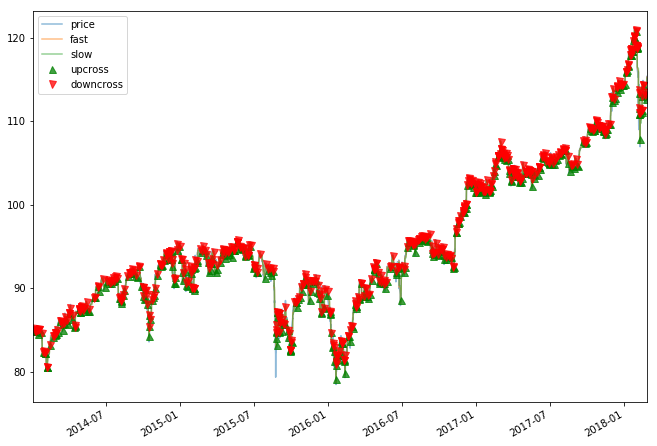

In [30]:
import matplotlib.pyplot as plt

up = crossover.get_up_cross(close_df)
down = crossover.get_down_cross(close_df)

f, ax = plt.subplots(figsize=(11,8))

close_df.loc['2014':].plot(ax=ax, alpha=.5)
up.loc['2014':].plot(ax=ax,ls='',marker='^', markersize=7,
                     alpha=0.75, label='upcross', color='g')
down.loc['2014':].plot(ax=ax,ls='',marker='v', markersize=7, 
                       alpha=0.75, label='downcross', color='r')

ax.legend()

In [31]:
side = crossover.get_side(close, fast_window, slow_window)
cprint(side)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                     0
2018-02-21 11:10:00  1
2018-02-21 15:12:30 -1
2018-02-22 11:48:39  1
2018-02-22 13:34:29 -1
2018-02-23 10:01:41  1
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1712 entries, 2009-09-30 09:45:21 to 2018-02-23 10:01:41
Data columns (total 1 columns):
0    1712 non-null int64
dtypes: int64(1)
memory usage: 26.8 KB
None
-------------------------------------------------------------------------------



In [32]:
minRet = .01 
ptsl=[1, 2]

labeller = lab.Labeller()

dailyVol = labeller.getDailyVol(close_df['price'])
tEvents = labeller.getTEvents(close_df['price'], h=dailyVol.mean())
t1 = labeller.addVerticalBarrier(tEvents, close_df['price'], numDays=1)

target=dailyVol

# Run in single-threaded mode on Windows

if platform.system() == "Windows":
    cpus = 1
else:
    cpus = cpu_count() - 1

ma_events = labeller.getEvents(close_df['price'], tEvents, ptsl, target, minRet, cpus, t1=t1, side=side)
cprint(ma_events)

  0%|          | 0/30858 [00:00<?, ?it/s]

  2%|▏         | 512/30858 [00:00<00:05, 5118.31it/s]

  4%|▍         | 1244/30858 [00:00<00:05, 5625.69it/s]

  6%|▋         | 1973/30858 [00:00<00:04, 6038.35it/s]

  9%|▊         | 2700/30858 [00:00<00:04, 6357.12it/s]

 11%|█         | 3429/30858 [00:00<00:04, 6609.91it/s]

 14%|█▎        | 4174/30858 [00:00<00:03, 6839.91it/s]

 16%|█▌        | 4936/30858 [00:00<00:03, 7055.67it/s]

 18%|█▊        | 5641/30858 [00:00<00:03, 7052.85it/s]

 21%|██        | 6357/30858 [00:00<00:03, 7083.23it/s]

 23%|██▎       | 7068/30858 [00:01<00:03, 7088.97it/s]

 25%|██▌       | 7791/30858 [00:01<00:03, 7127.72it/s]

 28%|██▊       | 8497/30858 [00:01<00:03, 7031.22it/s]

 30%|███       | 9287/30858 [00:01<00:02, 7270.34it/s]

 33%|███▎      | 10042/30858 [00:01<00:02, 7351.25it/s]

 35%|███▌      | 10816/30858 [00:01<00:02, 7461.94it/s]

 38%|███▊      | 11582/30858 [00:01<00:02, 7519.37it/s]

 40%|████      | 12353/30858 [00:01<00:02, 7573.64it/s]

 43%|████▎     | 13129/30858 [00:01<00:02, 7628.40it/s]

 45%|████▌     | 13895/30858 [00:01<00:02, 7636.74it/s]

 48%|████▊     | 14666/30858 [00:02<00:02, 7658.20it/s]

 50%|█████     | 15442/30858 [00:02<00:02, 7685.49it/s]

 53%|█████▎    | 16219/30858 [00:02<00:01, 7707.88it/s]

 55%|█████▌    | 16995/30858 [00:02<00:01, 7721.45it/s]

 58%|█████▊    | 17768/30858 [00:02<00:01, 7708.62it/s]

 60%|██████    | 18548/30858 [00:02<00:01, 7734.38it/s]

 63%|██████▎   | 19322/30858 [00:02<00:01, 7733.91it/s]

 65%|██████▌   | 20108/30858 [00:02<00:01, 7769.51it/s]

 68%|██████▊   | 20886/30858 [00:02<00:01, 7755.13it/s]

 70%|███████   | 21671/30858 [00:02<00:01, 7782.14it/s]

 73%|███████▎  | 22450/30858 [00:03<00:01, 7757.36it/s]

 75%|███████▌  | 23231/30858 [00:03<00:00, 7771.64it/s]

 78%|███████▊  | 24009/30858 [00:03<00:00, 7752.42it/s]

 80%|████████  | 24785/30858 [00:03<00:00, 7747.84it/s]

 83%|████████▎ | 25561/30858 [00:03<00:00, 7748.88it/s]

 85%|████████▌ | 26336/30858 [00:03<00:00, 7727.83it/s]

 88%|████████▊ | 27109/30858 [00:03<00:00, 7688.28it/s]

 90%|█████████ | 27878/30858 [00:03<00:00, 7682.53it/s]

 93%|█████████▎| 28650/30858 [00:03<00:00, 7691.89it/s]

 95%|█████████▌| 29429/30858 [00:03<00:00, 7720.61it/s]

 98%|█████████▊| 30209/30858 [00:04<00:00, 7743.26it/s]

100%|██████████| 30858/30858 [00:04<00:00, 7530.28it/s]

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                     side                  t1      trgt
2018-02-13 13:43:37   NaN 2018-02-14 13:53:59  0.014365
2018-02-14 10:30:48   NaN 2018-02-15 10:42:27  0.012136
2018-02-14 13:36:02   NaN 2018-02-15 13:42:09  0.011688
2018-02-15 09:31:56   NaN 2018-02-16 09:42:36  0.011244
2018-02-15 14:05:41   NaN 2018-02-16 14:15:08  0.010183
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 929 entries, 2009-10-05 14:55:48 to 2018-02-15 14:05:41
Data columns (total 3 columns):
side    102 non-null float64
t1      929 non-null datetime64[ns]
trgt    929 non-null float64
dtypes: datetime64[ns](1), float64(2)
memory usage: 29.0 KB
None
-------------------------------------------------------------------------------



2019-03-17 15:57:22.334385 100.0% applyPtSlOnT1 done after 0.02 minutes. Remaining 0.0 minutes.


In [33]:
ma_events.side.value_counts()

 1.0    53
-1.0    49
Name: side, dtype: int64

In [34]:
ma_side = ma_events.dropna().side
ma_bins = labeller.getBinsNew(ma_events,close_df['price'], t1).dropna()
cprint(ma_bins)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                          ret  bin
2016-07-07 14:28:00 -0.018703  0.0
2016-07-08 09:30:57  0.010571  1.0
2018-02-06 10:18:08 -0.026702  0.0
2018-02-07 15:28:09 -0.030792  0.0
2018-02-13 09:30:00 -0.001803  0.0
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 102 entries, 2009-10-29 13:40:22 to 2018-02-13 09:30:00
Data columns (total 2 columns):
ret    102 non-null float64
bin    102 non-null float64
dtypes: float64(2)
memory usage: 2.4 KB
None
-------------------------------------------------------------------------------



In [36]:
Xx = pd.merge_asof(ma_bins, side.to_frame().rename(columns={0:'side'}),
                   left_index=True, right_index=True, direction='forward')

parq_file_name = file_name + '_cross_train_label' + file_ext
# Save to parquet
outfp = PurePath(data_processed_dir / parq_file_name)
Xx.to_parquet(outfp)

cprint(Xx)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
                          ret  bin  side
2016-07-07 14:28:00 -0.018703  0.0    -1
2016-07-08 09:30:57  0.010571  1.0     1
2018-02-06 10:18:08 -0.026702  0.0    -1
2018-02-07 15:28:09 -0.030792  0.0     1
2018-02-13 09:30:00 -0.001803  0.0    -1
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 102 entries, 2009-10-29 13:40:22 to 2018-02-13 09:30:00
Data columns (total 3 columns):
ret     102 non-null float64
bin     102 non-null float64
side    102 non-null int64
dtypes: float64(2), int64(1)
memory usage: 3.2 KB
None
-------------------------------------------------------------------------------

